# Zeropoint and sky Background and ADC counts for Auxtel

- Author : Sylvie Dagoret-Campagne
- creation date : 2024-05-11
- last update : 2024-05-12
- affiliation : IJCLab/IN2P3/CNRS

In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint

from scipy import interpolate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.colors import ListedColormap
from matplotlib import colors

In [2]:
from IPython.display import Image

In [3]:
plt.rcParams["figure.figsize"] = (18,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


In [5]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data.data_sets import  get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 

## Configuration

### Configuration of input path

In [6]:
atmosphere_std_filename = "atmos_std.dat"

hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]

hardware_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"] 
filter_filenames = ["auxtel_sdss_up.dat","auxtel_sdss_gp.dat","auxtel_sdss_rp.dat","auxtel_sdss_ip.dat","auxtel_sdss_zp.dat" ,"auxtel_sdss_yp.dat"]
total_filenames = ["auxtel_sdss_up_total.dat","auxtel_sdss_gp_total.dat","auxtel_sdss_rp_total.dat","auxtel_sdss_ip_total.dat","auxtel_sdss_zp_total.dat","auxtel_sdss_yp_total.dat"]


filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Z","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

FILTERWL = np.array([[ 353.        ,  385.        ,  369.        ,   32.        ],
                  [ 393.        ,  560.        ,  476.5       ,  167.        ],
                  [ 557.        ,  703.        ,  630.        ,  146.        ],
                  [ 688.        ,  859.        ,  773.5       ,  171.        ],
                  [ 812.        ,  938.        ,  875.76271186,  126.        ],
                  [ 934.        , 1060.        ,  997.        ,  126.        ]])



### Configuration of telescope/camera photometric parameters

In [7]:
F0 = 3631.0 # Jy 1, Jy = 10^{-23} erg.cm^{-2}.s^{-1}.Hz^{-1}
# 1 Jy = 10−26 W.Hz−1.m−2 = 10−23 erg cm−2.s−1.Hz−1
Jy_to_ergcmm2sm1hzm1 = 1e-23

DT = 30.0 # seconds
gel = 1.08269375
#hP = 6.62607015E-34 # J⋅Hz−1
hP = 6.626196E-27 # erg.s
A  = 9636.0 # cm2  Reff=1.2 m
pixel_scale = 0.1 #arcsec/pixel
readnoise = 8.96875
D = 1.11 # m true diameter
def set_photometric_parameters(exptime, nexp, readnoise=readnoise):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [8]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [9]:
photoparams = set_photometric_parameters(DT, 1 , readnoise=readnoise )
photoparams._gain = gel
photoparams._exptime = DT
photoparams._effarea = A
photoparams._platescale = pixel_scale

$$
F_{obs}(ADU) = F_0 \frac{A.Dt}{gh} \int \left( \frac{F_\nu(\lambda)}{F_0}\right) S^{syst}(\lambda)S^{atm}(\lambda) \frac{d\lambda}{\lambda}
$$

- defining K0 in units of electrons for a reference source with a magnitude of 25 mag:
- where the exposure time is 30 s and the effective surface is related with a collection diameter D = 1.2 m

In [10]:
K0 = (F0*Jy_to_ergcmm2sm1hzm1)*(np.pi*(1.2)**2/4*1e4)*DT/hP*np.power(10,-0.4*25.0)
#K0 = (F0*Jy_to_ergcmm2sm1hzm1)*A*DT/hP*np.power(10,-0.4*25.0)
K0

185.9240619987592

### Ratio for ADU counts between LSST/Auxtel 

In [11]:
K0_auxtel = K0
K0_lsst = 5455.063624616373

In [12]:
Surf_ratio = 324015.4546769212/9636.0
PixScale_ratio = (0.2/0.1)**2
K0_ratio_sig = K0_lsst/K0_auxtel
K0_ratio_bkg = K0_ratio_sig*(0.2/0.1)
gel_ratio = 1.693343125/gel

In [13]:
print(f" Surface_ratio = {Surf_ratio:.2f}")
print(f" PixScale_ratio = {PixScale_ratio:.2f}")
print(f" K0_ratio_sig = {K0_ratio_sig:.2f}")
print(f" K0_ratio_bkg = {K0_ratio_bkg:.2f}")

 Surface_ratio = 33.63
 PixScale_ratio = 4.00
 K0_ratio_sig = 29.34
 K0_ratio_bkg = 58.68


In [14]:
def func_Cb(m0,dt,Tb):
    Cb = K0/gel*np.power(10.0,0.4*(25-m0))*(D/1.2)**2*(dt/DT)*Tb
    return Cb
def func_ZP(Tb):
    Zb = 181.6/gel*(D/1.2)**2*Tb
    mZP = 25.0+2.5*np.log10(Zb)
    return mZP
def func_Bb(m_sky,dt,Sigb):
    Bb = func_Cb(m_sky,dt,Sigb)*(pixel_scale)**2
    return Bb

## Read input files

In [15]:
fdir = get_data_dir()
print(f"path for input data : {fdir}")
# path for Bandpass for lsstsim : throughputs/baseline
path_rubin_sim_throughput = os.path.join(fdir, 'throughputs', 'auxtel')

path for input data : /Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubin_sim_data


### Atmospheric transmission

In [16]:
atm_fullfilename = os.path.join(fdir,'throughputs','baseline',atmosphere_std_filename)
arr= np.loadtxt(atm_fullfilename)
fatm = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
atm = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

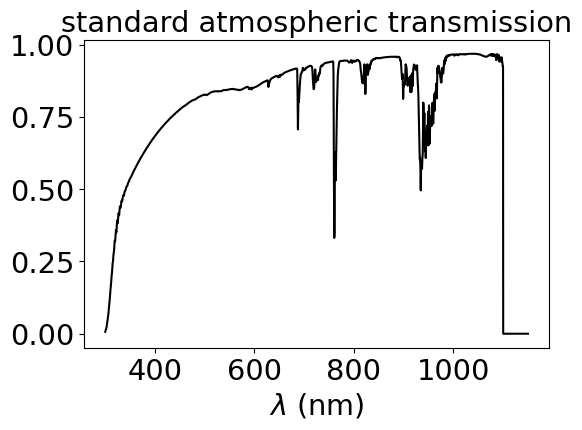

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(atm.wavelen,atm.sb,color="k")   
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_title("standard atmospheric transmission")
plt.show()

### Instrumental Filter , no atmosphere

In [18]:
bandpass_inst = {}
for index,filename in enumerate(hardware_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    fname = filter_tagnames[index]
    bandpass_inst[fname] = Bandpass(wavelen=arr[:,0],sb=arr[:,1])

Text(0.5, 1.0, 'Instrument throughput')

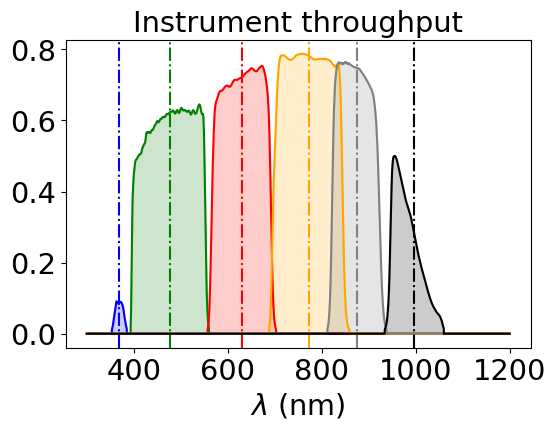

In [19]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_inst[f].wavelen,bandpass_inst[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument throughput")


In [20]:
all_Sigb = {}

for index,f in enumerate(filter_tagnames): 
    wl = bandpass_inst[f].wavelen
    tr = bandpass_inst[f].sb
    Sigb = np.trapz(tr/wl,wl)
    all_Sigb[f] = Sigb 

In [21]:
pd.DataFrame(all_Sigb, index=['Sigmab']).round(4)

,u,g,r,i,z,y
Sigmab,0.0055,0.1961,0.1434,0.1481,0.085,0.03


In [22]:
all_Sigb_lsst = {'u': 0.05799681211198439,
 'g': 0.15435753686384943,
 'r': 0.11568976468947773,
 'i': 0.08549265799288006,
 'z': 0.0578713346676398,
 'y': 0.030944286687777878}

In [23]:
all_Sigb_ratio = {}
for index,f in enumerate(filter_tagnames): 
    all_Sigb_ratio[f] = all_Sigb_lsst[f]/all_Sigb[f]
pd.DataFrame(all_Sigb_ratio, index=['Sigb ratio LSST/Auxtel']).round(4)

,u,g,r,i,z,y
Sigb ratio LSST/Auxtel,10.5601,0.7873,0.8068,0.5772,0.6807,1.0301


### total Filter , with atmosphere

In [24]:
bandpass_total = {}
for index,filename in enumerate(total_filenames):
    fullfilename=os.path.join(path_rubin_sim_throughput,filename)
    arr= np.loadtxt(fullfilename)
    ftr = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    fname = filter_tagnames[index]
    bandpass_total[fname] = Bandpass(wavelen=WL,sb=ftr(WL)*fatm(WL))

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


Text(0.5, 1.0, 'Total throughput')

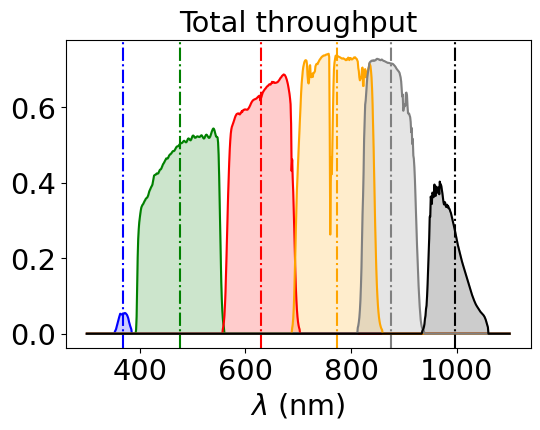

In [25]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
# loop on filter
for index,f in enumerate(filter_tagnames): 
    axs.plot(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index]) 
    axs.fill_between(bandpass_total[f].wavelen,bandpass_total[f].sb,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Total throughput")

In [26]:
all_Tb = {}
for index,f in enumerate(filter_tagnames): 
    wl = bandpass_total[f].wavelen
    tr = bandpass_total[f].sb
    Tb = np.trapz(tr/wl,wl)
    all_Tb[f] = Tb 

In [27]:
pd.DataFrame(all_Tb, index=['Tb']).round(4)

,u,g,r,i,z,y
Tb,0.0033,0.1547,0.1253,0.1344,0.0791,0.0262


In [28]:
all_Tb_lsst = {'u': 0.033336214101484685,
 'g': 0.1219232624559762,
 'r': 0.10070846019713751,
 'i': 0.0771272212427603,
 'z': 0.05372305003237012,
 'y': 0.025933422423764004}

##### Get the Tb ratio between LSST and Auxtel

In [29]:
all_Tb_ratio = {}
for index,f in enumerate(filter_tagnames): 
    all_Tb_ratio[f] = all_Tb_lsst[f]/all_Tb[f]
pd.DataFrame(all_Tb_ratio, index=['Tb ratio LSST/Auxtel']).round(4)

,u,g,r,i,z,y
Tb ratio LSST/Auxtel,10.1291,0.7881,0.8039,0.5741,0.6792,0.9909


## Source Count in an AB-Source

### Info from LSE-40

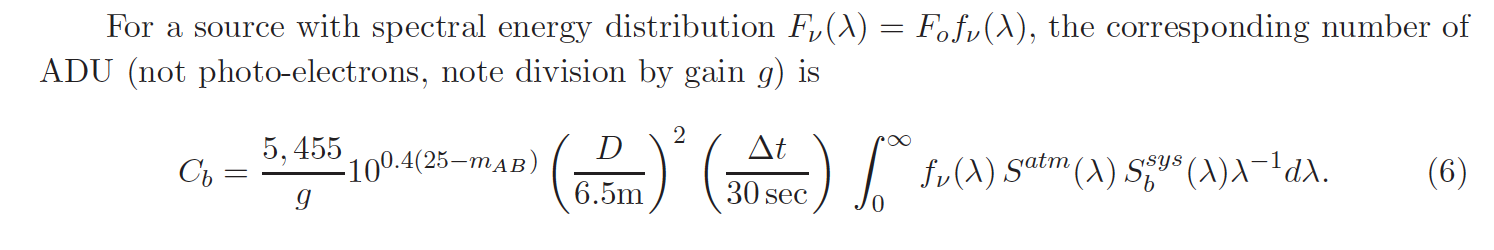

In [30]:
Image(filename='./images/CbRateFull.png',width=800)

### Calculate Magnitude for the flat SED for AB source

In [31]:
sed_flat = Sed()
sed_flat.set_flat_sed()
flux_norm = sed_flat.calc_flux_norm(0, bandpass_total['g'])
sed_flat.multiply_flux_norm(flux_norm)

In [32]:
wl,fnu = sed_flat.get_sed_fnu()
wl,fl = sed_flat.get_sed_flambda()

Text(0.5, 1.0, 'Flat SED for AB source')

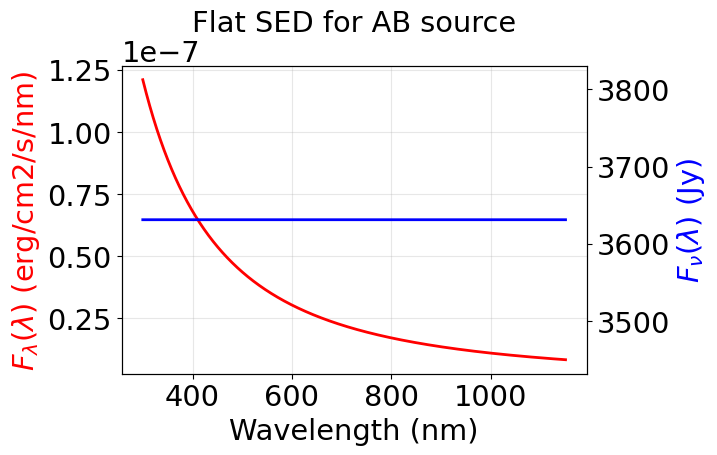

In [33]:
fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.plot(wl, fl,"-",color="r",label = "$f_\lambda$",lw=2)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\lambda (\lambda)$ (erg/cm2/s/nm)",color="r")

ax2 =ax.twinx()
ax2.plot(wl, fnu,"-",color="b",label = "$f_\nu$",lw=2)
ax2.set_ylabel("$F_\\nu (\lambda)$ (Jy)",color="b")

ax.set_title("Flat SED for AB source")

#### AB source mag 

In [34]:
# Calculate the standard AB source mag - for reference
AB_mags = {}

for index,f in enumerate(filter_tagnames):
    AB_mags[f] = sed_flat.calc_mag(bandpass_total[f])
    
pd.DataFrame(AB_mags, index=['AB source mag']).round(2)

,u,g,r,i,z,y
AB source mag,0.0,0.0,0.0,0.0,0.0,0.0


#### AB source ADU rate (per pixel per second)

In [35]:
# Need to select an exposure of 1 second as the zero-point refers to a flux of 1 ADU/sec
photoparams._exptime = 1.0

In [36]:
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


##### Use rubinsimphot

In [37]:
# Calculate the standard zero magnitudes - for reference
AB_adu = {}

for index,f in enumerate(filter_tagnames):
    AB_adu[f] = sed_flat.calc_adu(bandpass_total[f],photoparams)
    
pd.DataFrame(AB_adu, index=['AB source ADU/pix/s']).round(2)

,u,g,r,i,z,y
AB source ADU/pix/s,1.605118e+08,7.544940e+09,6.109792e+09,6.552673e+09,3.857415e+09,1.276435e+09


##### Check with the formula

In [38]:
AB_mag0_adu_calc = {}
for index,f in enumerate(filter_tagnames):
    cb = func_Cb(m0=0.0,dt=1.0,Tb=all_Tb[f])
    AB_mag0_adu_calc[f] = cb

pd.DataFrame(AB_mag0_adu_calc, index=['AB source calc ADU/pix/s']).round(2)

,u,g,r,i,z,y
AB source calc ADU/pix/s,1.611898e+08,7.576811e+09,6.135601e+09,6.580352e+09,3.873709e+09,1.281826e+09


##### Check the ratio between LSST and Auxtel

In [39]:
AB_adu_lsst = {'u': 34954846043.57571,
 'g': 127843217448.29796,
 'r': 105598335514.64185,
 'i': 80872115114.87799,
 'z': 56331559941.270546,
 'y': 27192613577.71615}

In [40]:
ratio_aducounts = {} 
for index,f in enumerate(filter_tagnames):
    ratio_aducounts[f] = AB_adu_lsst[f]/AB_adu[f]
pd.DataFrame(ratio_aducounts, index=['ADU count LSST/ADU counts Auxtel']).round(2)

,u,g,r,i,z,y
ADU count LSST/ADU counts Auxtel,217.77,16.94,17.28,12.34,14.6,21.3


- we check the ADU ratio between LSST and Auxtel scales with
  $$
\propto S \times T_b/g_{el}
  $$

In [41]:
predicted_ratio_aducounts = {} 
for index,f in enumerate(filter_tagnames):
    predicted_ratio_aducounts[f] = Surf_ratio*all_Tb_ratio[f]/gel_ratio 
pd.DataFrame(predicted_ratio_aducounts, index=['ADU count LSST/ADU counts Auxtel']).round(2)

,u,g,r,i,z,y
ADU count LSST/ADU counts Auxtel,217.77,16.94,17.28,12.34,14.6,21.3


#### Magnitude 20 source (per pixel per second)

In [42]:
flux_norm = sed_flat.calc_flux_norm(20, bandpass_total['g'])
sed_flat.multiply_flux_norm(flux_norm)

In [43]:
# Calculate the standard dark sky zenith magnitudes - for reference
AB_adu = {}

for index,f in enumerate(filter_tagnames):
    AB_adu[f] = sed_flat.calc_adu(bandpass_total[f],photoparams)
    
pd.DataFrame(AB_adu, index=['AB-mag20 source ADU/pix/s']).round(2)

,u,g,r,i,z,y
AB-mag20 source ADU/pix/s,1.61,75.45,61.1,65.53,38.57,12.76


In [44]:
adu_lsst = {'u': 349.54846043575714,
 'g': 1278.4321744829797,
 'r': 1055.9833551464185,
 'i': 808.7211511487803,
 'z': 563.3155994127056,
 'y': 271.9261357771615}

In [45]:
ratio_aducounts = {} 
for index,f in enumerate(filter_tagnames):
    ratio_aducounts[f] = adu_lsst[f]/AB_adu[f]
pd.DataFrame(ratio_aducounts, index=['ADU count LSST/ADU counts Auxtel']).round(2)

,u,g,r,i,z,y
ADU count LSST/ADU counts Auxtel,217.77,16.94,17.28,12.34,14.6,21.3


## Zero Point

### Info from note LSE-40

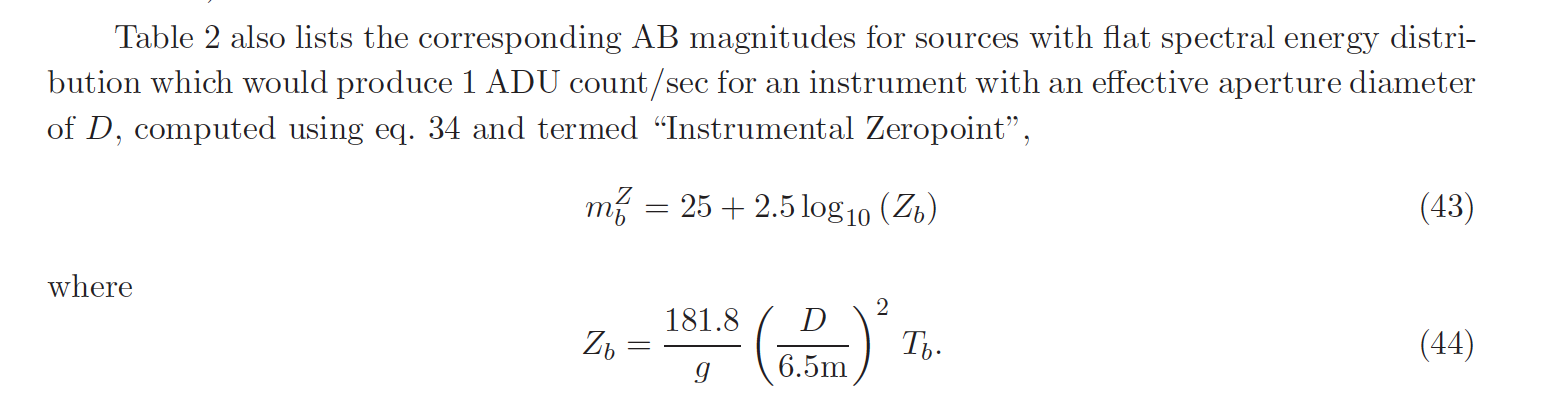

In [46]:
Image(filename='./images/ZeroPointFormula.png')

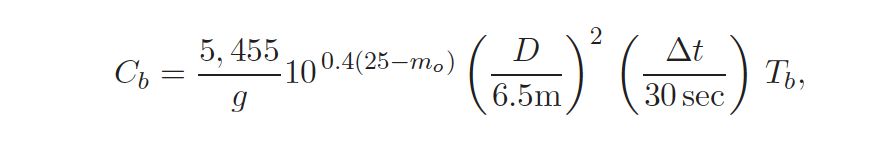

In [47]:
Image(filename='./images/CbRateShort.png',width=500)

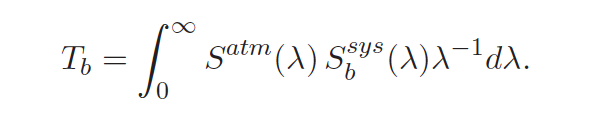

In [48]:
Image(filename='./images/Tb.png',width=400)

In [49]:
# Need to select an exposure of 1 second as the zero-point refers to a flux of 1 ADU/sec
photoparams._exptime = 1.0

In [50]:
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


In [51]:
# Calculate the standard dark sky zenith magnitudes - for reference
zeropoint_mags = {}

for index,f in enumerate(filter_tagnames):
   
    zp = bandpass_total[f].calc_zp_t(photoparams)
    zeropoint_mags[f] = zp
    
pd.DataFrame(zeropoint_mags, index=['ZP (mag)']).round(2)

,u,g,r,i,z,y
ZP (mag),20.51,24.69,24.47,24.54,23.97,22.76


##### Check zero-point compared to LSST

In [52]:
zeropoint_mags_lsst = {'u': 26.35876848411617,
 'g': 27.766694230144953,
 'r': 27.559142681798857,
 'i': 27.269497004298977,
 'z': 26.87687944486032,
 'y': 26.08612737790871}

In [53]:
zeropoint_mags_diff = {}
for index,f in enumerate(filter_tagnames):
    zeropoint_mags_diff[f] = zeropoint_mags_lsst[f] - zeropoint_mags[f]
pd.DataFrame(zeropoint_mags_diff, index=['Delta ZP (mag)']).round(2)

,u,g,r,i,z,y
Delta ZP (mag),5.85,3.07,3.09,2.73,2.91,3.32


In [54]:
predicted_zeropoint_magdiff = {} 
for index,f in enumerate(filter_tagnames):
    predicted_zeropoint_magdiff[f] = 2.5*np.log10(Surf_ratio*all_Tb_ratio[f]/gel_ratio) 
pd.DataFrame(predicted_zeropoint_magdiff, index=['predicted ZP-LSST - ZP-auxtel']).round(2)

,u,g,r,i,z,y
predicted ZP-LSST - ZP-auxtel,5.85,3.07,3.09,2.73,2.91,3.32


- Whe check the zero point difference between LSST and Auxtel 
is related 
$$
\propto 2.5\times \log_{10}\left( S \times T_b/g_{el}\right)
$$

## Sky Background

### Get Sky Spectrum
https://github.com/sylvielsstfr/rubinsimphot/blob/main/src/rubinsimphot/phot_utils/sed.py

In [55]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(fdir,'throughputs','baseline', 'darksky.dat'))

Text(0, 0.5, '$F_\\nu (\\lambda)$ (Jy)')

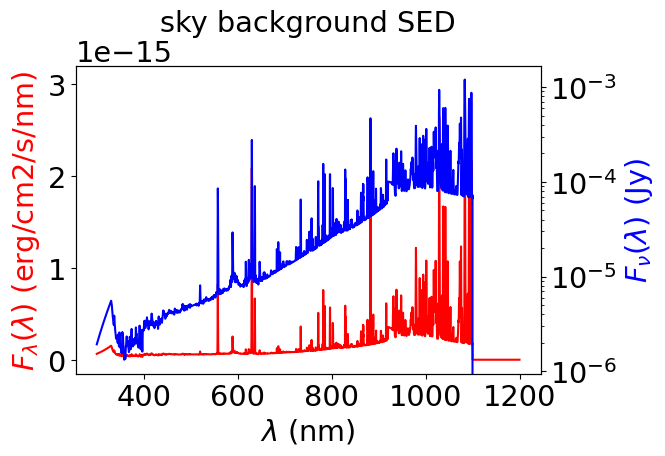

In [56]:
fig, ax1 = plt.subplots(1,1,figsize=(6,4))
ax1.plot(darksky.wavelen,darksky.flambda,'r-',label="$F_\lambda (\lambda)$")
#axs.plot(darksel.wavelen,darksel.flambda,'b-')
ax1.set_title("sky background SED")
ax1.set_xlabel("$\\lambda$ (nm)")
ax1.set_ylabel("$F_\lambda (\lambda)$ (erg/cm2/s/nm)",color="r")
ax2 = ax1.twinx()
wl,fnu = darksky.get_sed_fnu()
ax2.plot(wl,fnu,"b-",label="$F_\\nu (\lambda)$")
ax2.set_yscale("log")
ax2.set_ylabel("$F_\\nu (\lambda)$ (Jy)",color="b")

### Dark-Sky Magnitude

#### Info from LSE-40

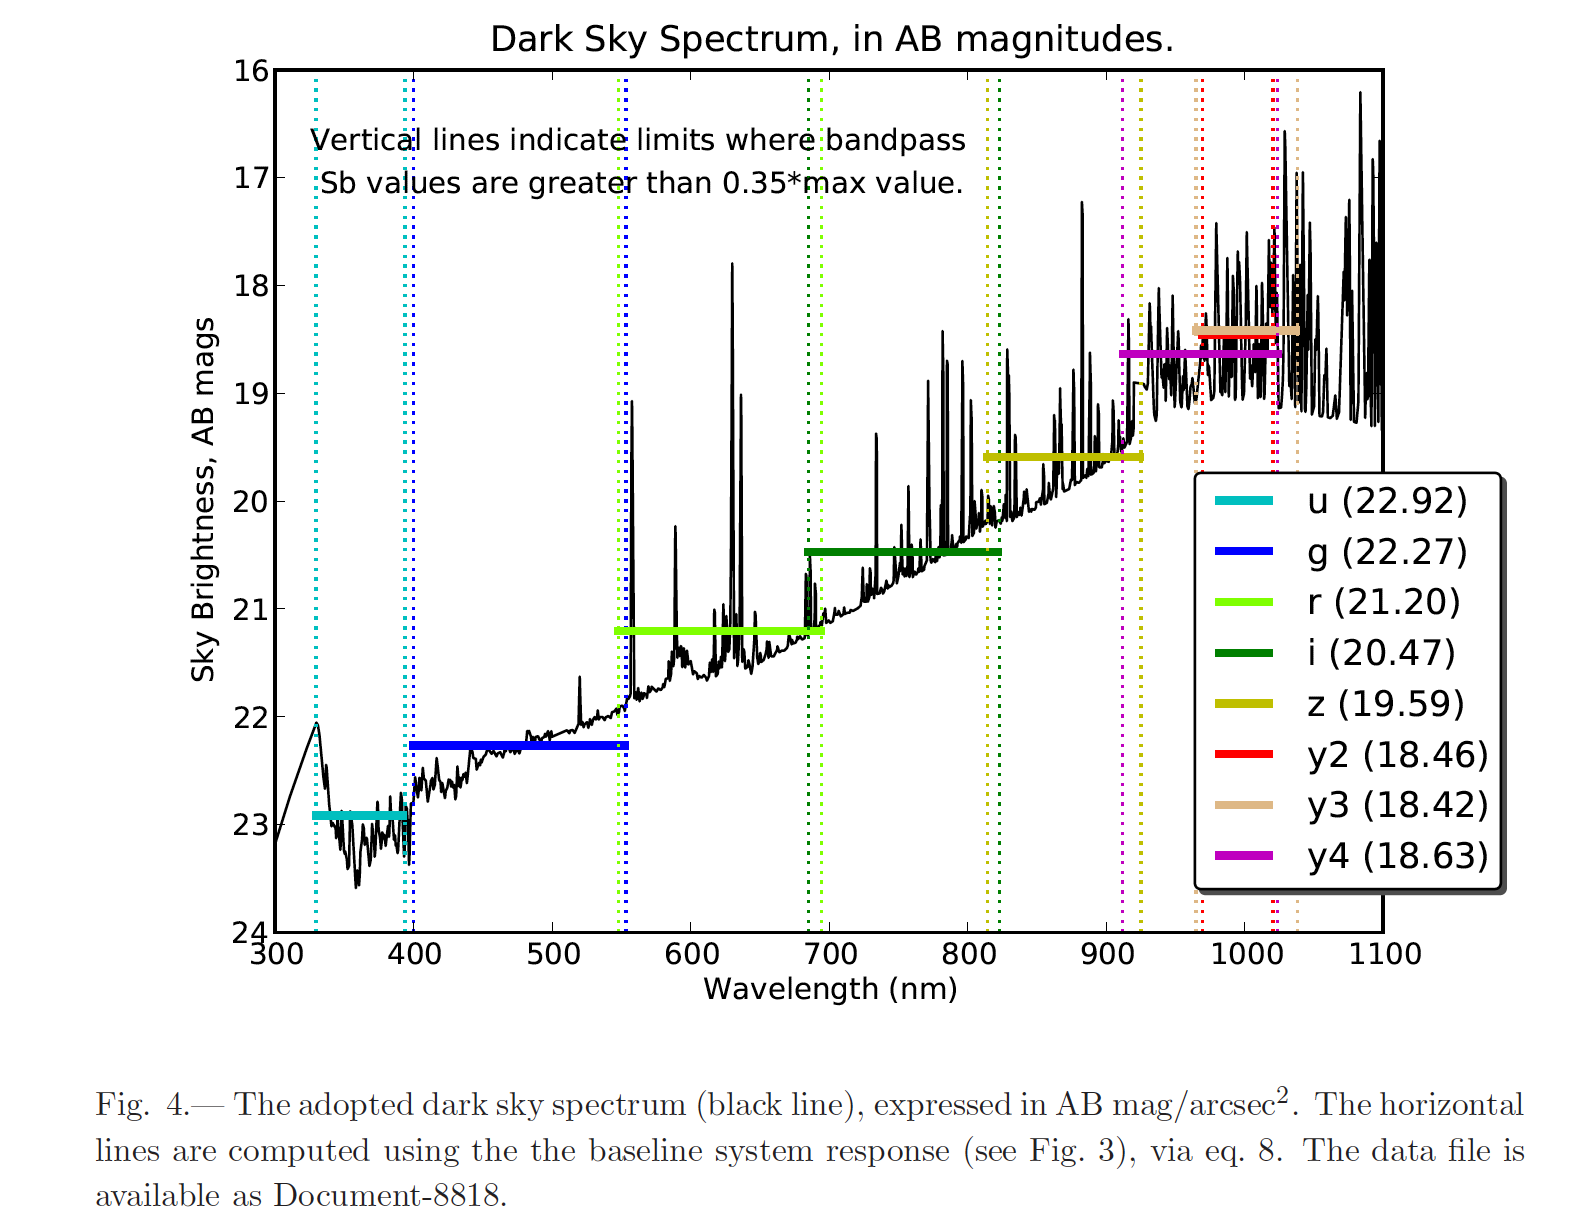

In [57]:
Image(filename='./images/SEDSkyBackground.png')

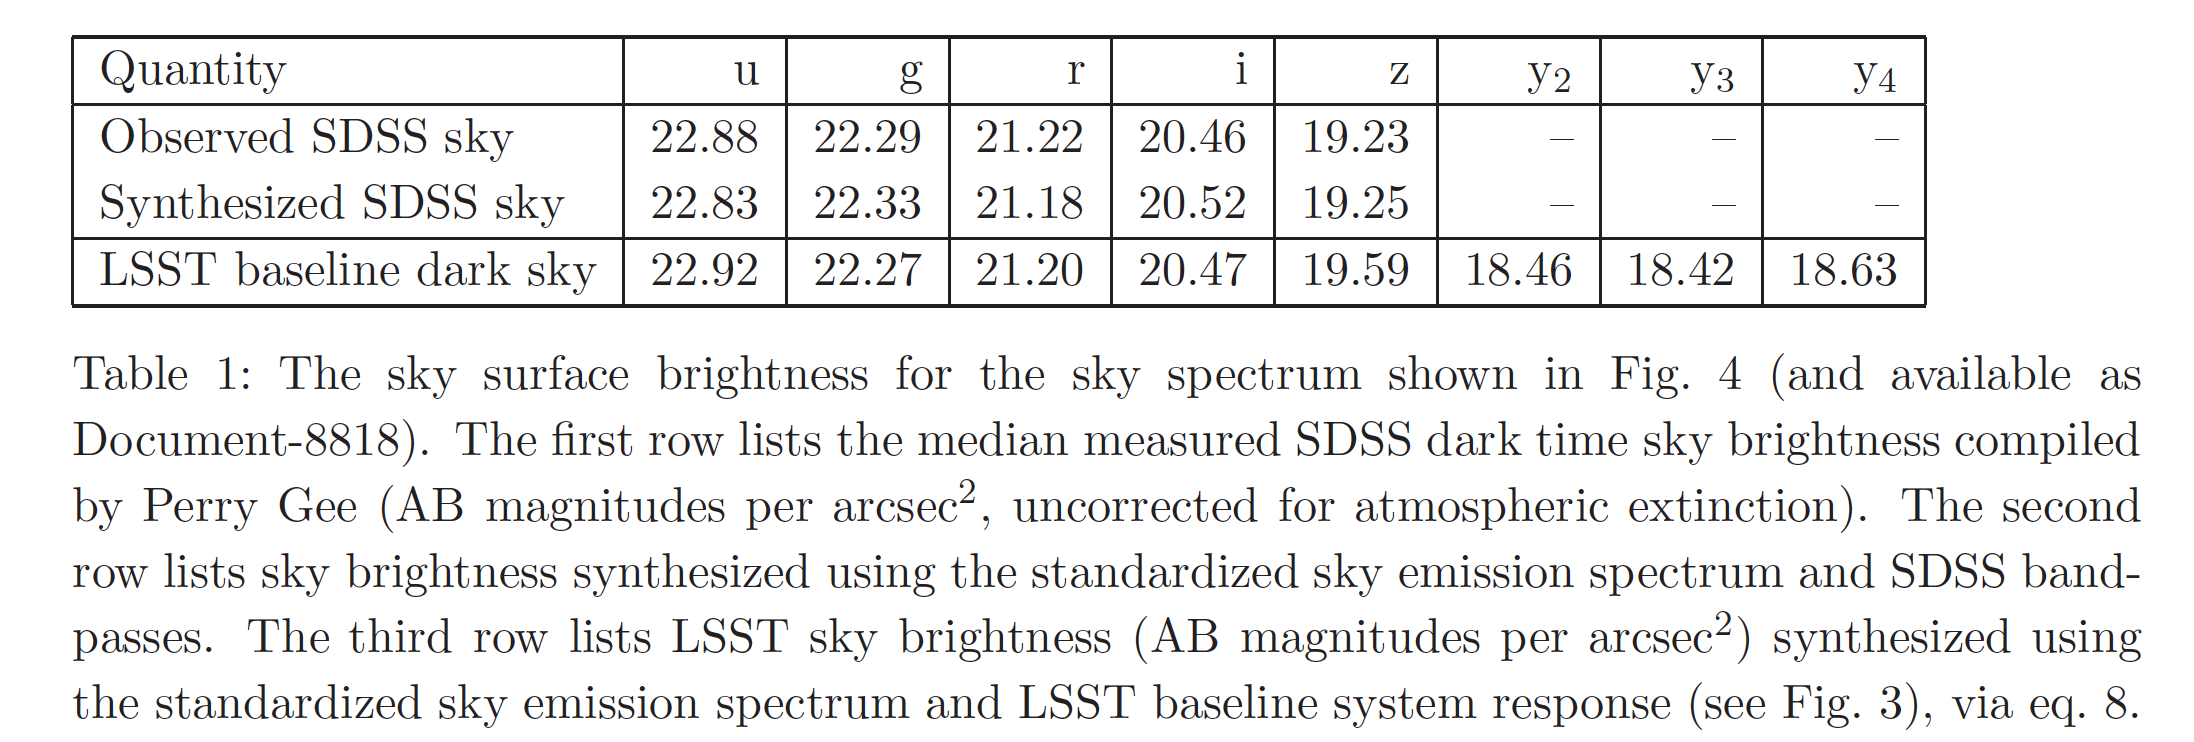

In [58]:
Image(filename='./images/LSSTSkyBackground.png')

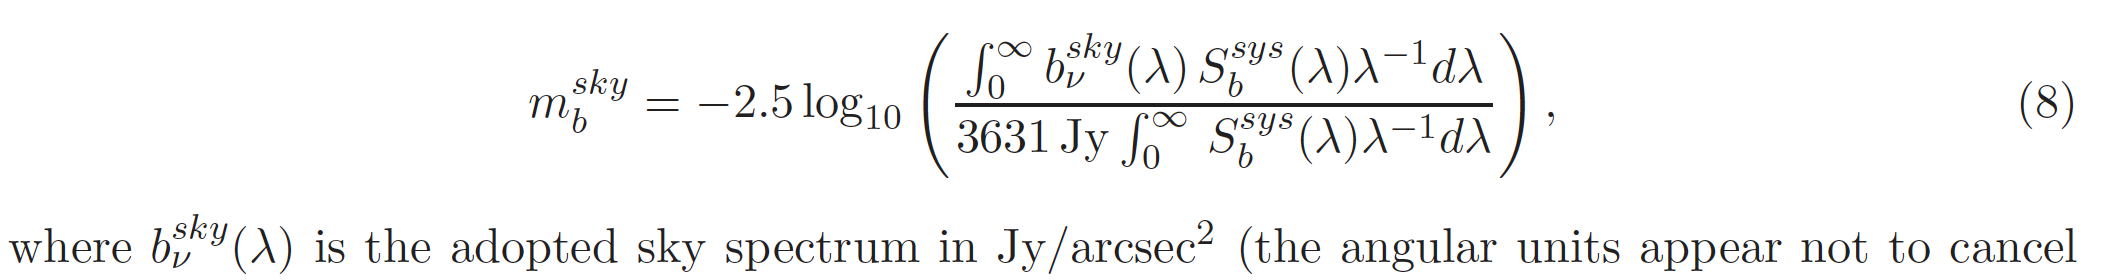

In [59]:
Image(filename='./images/MagnitudeSkyBackground.png')

#### Calculation from rubinsimphot

In [60]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_mags = {}

for index,f in enumerate(filter_tagnames):
    darksky_mags[f] = darksky.calc_mag(bandpass_inst[f])
    
pd.DataFrame(darksky_mags, index=['Dark-Sky mag/arcsec']).round(2)

,u,g,r,i,z,y
Dark-Sky mag/arcsec,23.16,22.28,21.17,20.34,19.59,18.57


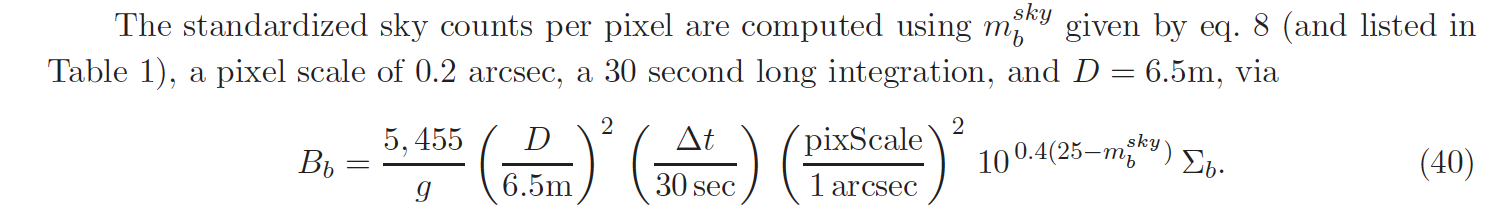

In [61]:
Image(filename='./images/Bb.png',width=800)

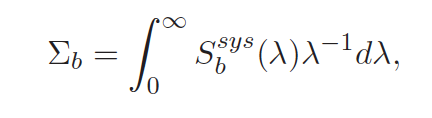

In [62]:
Image(filename='./images/Sigmab.png',width=200)

### Dark-Sky ADU/sec

In [63]:
# need to specify an exposure of 1 second as in the above tables counts are per second
photoparams._exptime = 1. 
pprint(vars(photoparams))

{'_bandpass': None,
 '_darkcurrent': 0.2,
 '_effarea': 9636.0,
 '_exptime': 1.0,
 '_gain': 1.08269375,
 '_nexp': 1,
 '_othernoise': 0.0,
 '_platescale': 0.1,
 '_readnoise': 8.96875,
 '_sigma_sys': 0.005}


##### Caculate with rubinsimphot

In [64]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu[f] = darksky.calc_adu(bandpass_inst[f],photoparams)*pixel_scale**2
    
pd.DataFrame(darksky_adu, index=['Dark-Sky ADU/pix/s']).round(2)

,u,g,r,i,z,y
Dark-Sky ADU/pix/s,0.0,0.12,0.24,0.53,0.61,0.55


##### Check count ratio wrt LSST

In [65]:
darksky_adu_lsst = {'u': 1.5913406642162216,
 'g': 8.092370384753096,
 'r': 16.11796074800091,
 'i': 23.100019641683303,
 'z': 35.09807209732647,
 'y': 46.67341810128563}

In [66]:
ratio_darksky_aducounts = {} 
for index,f in enumerate(filter_tagnames):
    ratio_darksky_aducounts[f] = darksky_adu_lsst[f]/darksky_adu[f]
pd.DataFrame(ratio_darksky_aducounts, index=['ADU count LSST/ADU counts Auxtel']).round(2)

,u,g,r,i,z,y
ADU count LSST/ADU counts Auxtel,1090.03,69.08,67.86,43.72,57.81,85.07


- we check the dark-sky ADU ratio between LSST and Auxtel scales with
  $$
\propto S \times \Sigma_b/g_{el}*pixel\_scale^2
  $$

In [68]:
predicted_ratio_darksky_aducounts = {} 
for index,f in enumerate(filter_tagnames):
    predicted_ratio_darksky_aducounts[f] = Surf_ratio*all_Sigb_ratio[f]/gel_ratio* PixScale_ratio 
pd.DataFrame(predicted_ratio_darksky_aducounts, index=['ADU count LSST/ADU counts Auxtel']).round(2)

,u,g,r,i,z,y
ADU count LSST/ADU counts Auxtel,908.15,67.7,69.38,49.64,58.54,88.59


### Dark-Sky ADU/exposure

In [ ]:
photoparams._exptime = 30. 
pprint(vars(photoparams))

In [ ]:
# Calculate the standard dark sky zenith magnitudes - for reference
darksky_adu_expo = {}

for index,f in enumerate(filter_tagnames):
    darksky_adu_expo[f] = darksky.calc_adu(bandpass_inst[f],photoparams)*pixel_scale**2
    
pd.DataFrame(darksky_adu_expo, index=['Dark-Sky ADU/pix/expo']).round(2)